# Checking for rotation/translation order

In [185]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
directory = 'data_prep/output_test/scene3'
img_id = '00024'

In [187]:
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
import torch
import torchvision
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def plot_img_tensor(img, nrow=4):
    """Helper function to plot image tensors.
    
    Args:
        img (torch.Tensor): Image or batch of images of shape 
            (batch_size, channels, height, width).
    """
    img_grid = torchvision.utils.make_grid(img, nrow=nrow)
    plt.imshow(img_grid.cpu().numpy().transpose(1, 2, 0))

In [188]:
from models.neural_renderer import load_model

# Load trained chairs model
model = load_model('trained-models/chairs.pt').to(device)

/var/folders/n4/v_p7vlns5vd_ljr8d_pbswl00000gn/T/ipykernel_30496/240956524.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(directory + '/00000.png')[:, :, :3]


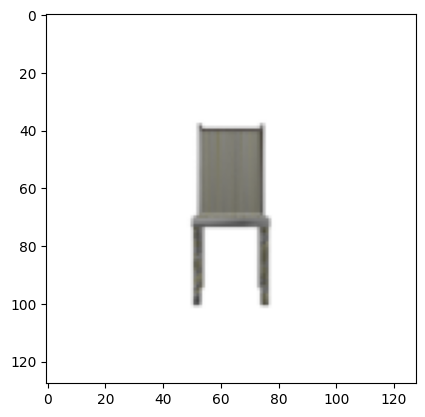

In [189]:
# You can also try loading other examples (e.g. 'chair1.png')
img = imageio.imread(directory + '/00000.png')[:, :, :3]
# Visualize image
plt.imshow(img)

In [190]:
from torchvision.transforms import ToTensor

# Convert image to tensor and add batch dimension
img_source = ToTensor()(img)
img_source = img_source.unsqueeze(0).to(device)

# Infer scene representation
scene = model.inverse_render(img_source)

# Print scene shape
print("Scene shape: {}".format(scene.shape))

Scene shape: torch.Size([1, 64, 32, 32, 32])


In [191]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision

def plot_img_tensor(img, nrow=4):
    """Helper function to plot image tensors.
    
    Args:
        img (torch.Tensor): Image or batch of images of shape 
            (batch_size, channels, height, width).
    """
    img_grid = torchvision.utils.make_grid(img, nrow=nrow)
    plt.imshow(img_grid.cpu().numpy().transpose(1, 2, 0))

## With angles

### Combined roto-translation

In [192]:
import json


def load_params(path, img_id="00000"):
    """Loads camera parameters from JSON file.
    
    Args:
        path (str): Path to JSON file.
        img_id (str): Image ID.
        
    Returns:
        dict: Dictionary of camera parameters.
    """
    with open(path, 'r') as f:
        params = json.load(f)
    return params[img_id]

load_params('data_prep/output_test/scene3/render_params.json', img_id="00000")

{'azimuth': 0.0, 'elevation': 0.0, 'x': -0.0, 'y': 0.0, 'z': 0.0}

params {'azimuth': -0.5742600087092851, 'elevation': -0.8250360654511276, 'x': -0.0, 'y': 0.32668623328208923, 'z': 0.2970970571041107}


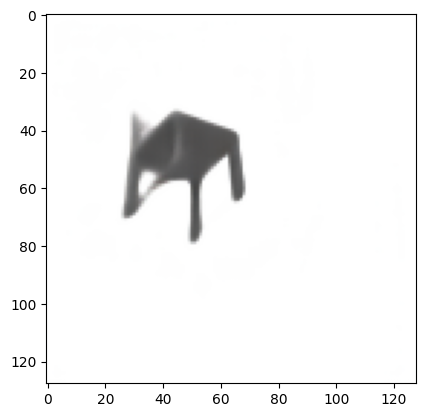

In [193]:
import math

def radians_to_degrees(radians):
    """Converts radians to degrees.
    
    Args:
        radians (torch.Tensor): Tensor of radians.
        
    Returns:
        torch.Tensor: Tensor of degrees.
    """
    return radians * (180 / math.pi)

path = directory + '/render_params.json'
params = load_params(path, img_id)
print('params', params)
azimuth = radians_to_degrees(params['azimuth'])
elevation = radians_to_degrees(params['elevation'])
#azimuth, elevation = elevation, azimuth
x = params['x']
y = params['y']
z = params['z']

# As a rotation matrix can feel a little abstract, we can also reason in terms of 
# camera azimuth and elevation. The initial coordinate at which the source image
# is observed is given by the following azimuth and elevation. Note that these
# are not necessary to generate novel views (as shown above), we just use them 
# for convenience to generate rotation matrices
azimuth_source = torch.Tensor([0.]).to(device)
elevation_source = torch.Tensor([0.]).to(device)
translations_source = torch.Tensor([0., 0., 0.]).to(device)

# You can set these to any value you like!
# Positive (negative) values correspond to moving camera to the right (left)
azimuth_shift = torch.Tensor([azimuth]).to(device)  
# Positive (negative) values correspond to moving camera up (down)
elevation_shift = torch.Tensor([elevation]).to(device)
# Translation values
translations_shift = torch.Tensor([x, y, z]).to(device)

azimuth_target = azimuth_source + azimuth_shift
elevation_target = elevation_source + elevation_shift
translations_target = translations_source + translations_shift

# Rotate scene to match target camera angle
translated_scene = model.rotate_source_to_target(
    scene, 
    azimuth_source, elevation_source, translations_source,
    azimuth_target, elevation_target, translations_target
)

# Render rotated scene
rendered = model.render(translated_scene)

plot_img_tensor(rendered.detach())

### Translate then rotate

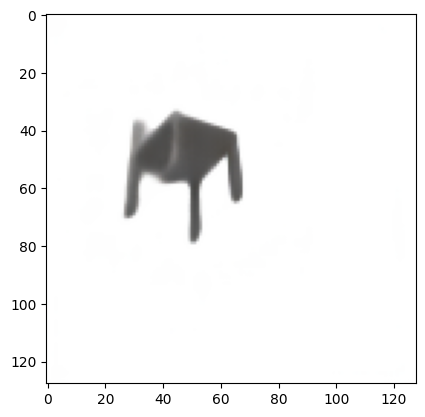

In [194]:
# Translate
translated_scene = model.rotate_source_to_target(
    scene, 
    azimuth_source, elevation_source, translations_source,
    azimuth_source, elevation_source, translations_target
)

# Rotate
rotated_translated_scene = model.rotate_source_to_target(
    translated_scene, 
    azimuth_source, elevation_source, translations_target,
    azimuth_target, elevation_target, translations_target
)

# Render rotated scene
rendered = model.render(rotated_translated_scene)

plot_img_tensor(rendered.detach())

### Rotate then translate

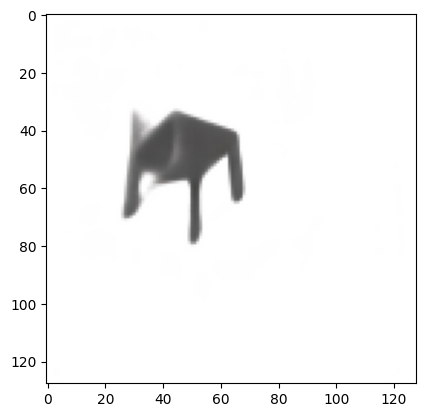

In [195]:
# Rotate
rotated_scene = model.rotate_source_to_target(
    scene, 
    azimuth_source, elevation_source, translations_source,
    azimuth_target, elevation_target, translations_source
)

# Translate
translated_rotated_scene = model.rotate_source_to_target(
    rotated_scene,
    azimuth_target, elevation_target, translations_source,
    azimuth_target, elevation_target, translations_target
)

# Render rotated scene
rendered = model.render(translated_rotated_scene)

plot_img_tensor(rendered.detach())

## Compare with Blender (Ground Truth)

/var/folders/n4/v_p7vlns5vd_ljr8d_pbswl00000gn/T/ipykernel_30496/2181985140.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(directory + '/' + img_id + '.png')[:, :, :3]


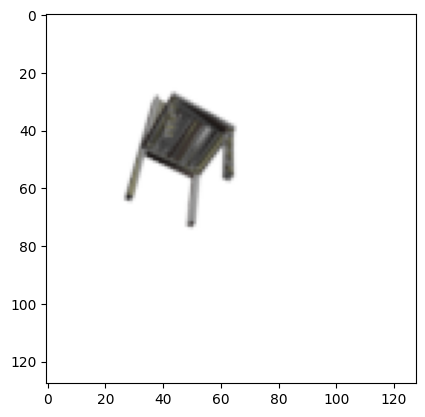

In [196]:
# You can also try loading other examples (e.g. 'chair1.png')
img = imageio.imread(directory + '/' + img_id + '.png')[:, :, :3]
# Visualize image
plt.imshow(img)